In [2]:
import numpy as np
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
def get_score(valid_y_exp, pred):
    return mean_absolute_error(pred, valid_y_exp)

In [4]:
path = "Dataset/AAl_T_Weather_SkewFix_19des-22mar.csv"

df_data = pd.read_csv(path)

In [5]:
df_data['Year'] = pd.to_datetime(df_data['Recorded']).dt.year
df_data['Weekday'] = pd.to_datetime(df_data['Recorded']).dt.weekday
df_data['Hour'] = pd.to_datetime(df_data['Recorded']).dt.hour
df_data['Month'] = pd.to_datetime(df_data['Recorded']).dt.month
df_data['Day'] = pd.to_datetime(df_data['Recorded']).dt.day

In [6]:
df_data = df_data.drop(columns=["wdir_cardinal","Recorded","Month", "Day", "pressure"])
#df_data = df_data.drop(columns=["wdir_cardinal","Recorded",'heat_index', 'rh', 'pressure', 'wdir', 'wspd', 'Weekday',
#        'Hour', 'Month', 'Day', 'Year'])
df_data.columns

Index(['NO2', 'NOx', 'O3', 'heat_index', 'rh', 'wdir', 'wspd', 'Year',
       'Weekday', 'Hour'],
      dtype='object')

In [7]:
train_Df = df_data[0:35520]
train_Data = train_Df[0:28416]
val_df = train_Df[28416:]

In [8]:
X_train = train_Data[0:-1].copy()
Y_train = train_Data[["NO2","NOx","O3"]].copy()

Y_train = Y_train[1:]

X_train = X_train.reset_index(drop=True)
Y_train = Y_train.reset_index(drop=True)

In [9]:
X_val = val_df[0:-1].copy()
Y_val = val_df[["NO2","NOx","O3"]].copy()
Y_val = Y_val[1:]

X_val = X_val.reset_index(drop=True)
Y_val = Y_val.reset_index(drop=True)

In [10]:
Xscaler = StandardScaler()
Xscaler.fit(X_train)
scaled_X_train = Xscaler.transform(X_train)
Yscaler = StandardScaler()
Yscaler.fit(Y_train)
scaled_y_train = Yscaler.transform(Y_train)

In [11]:
X_val_scaler = StandardScaler() # scale so that all the X data will range from 0 to 1
X_val_scaler.fit(X_val)
scaled_X_val = X_val_scaler.transform(X_val)
Y_val_scaler = StandardScaler()
Y_val_scaler.fit(Y_val)
scaled_y_val = Y_val_scaler.transform(Y_val)

In [17]:
n_input = 1 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 256 # Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)
valgenerator = TimeseriesGenerator(scaled_X_val,scaled_y_val,length=n_input, batch_size=b_size)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 12)                1104      
                                                                 
 dense_4 (Dense)             (None, 3)                 39        
                                                                 
Total params: 1,143
Trainable params: 1,143
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
111/111 - 2s - loss: 0.6706 - val_loss: 0.6040 - 2s/epoch - 14ms/step
Epoch 2/1000
111/111 - 0s - loss: 0.5345 - val_loss: 0.4888 - 210ms/epoch - 2ms/step
Epoch 3/1000
111/111 - 0s - loss: 0.4517 - val_loss: 0.4434 - 209ms/epoch - 2ms/step
Epoch 4/1000
111/111 - 0s - loss: 0.4163 - val_loss: 0.4177 - 212ms/epoch - 2ms/step
Epoch 5/1000
111/111 - 0s - loss: 0.3896 - val_loss: 0.3938 - 208ms/epoch - 2ms/step
Epoch 6/1000
111/111 - 0s

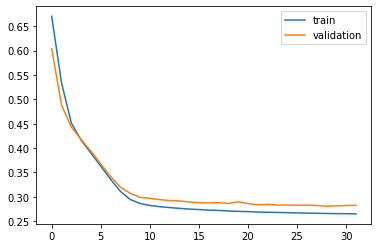

 Computing LSTM Feature importance...



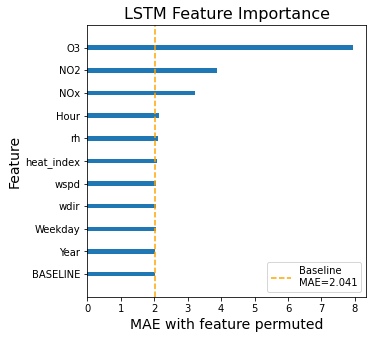

In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=3,
                                                    mode='min')

model = Sequential()
#model.add(Embedding(input_dim=48,output_dim=48))
model.add(LSTM(12, input_shape=(n_input, n_features),activation='tanh'))
#model.add()
# model.add(Dropout(0.1))
# model.add(Dense(30, activation='tanh'))
# model.add(Dropout(0.3))
model.add(Dense(3))

model.compile(loss='mae',optimizer='adam')
model.summary()

#history =model.fit(generator,epochs=5)
history = model.fit(generator, epochs=1000, shuffle=True,
                        validation_data=(valgenerator),
                        callbacks=[early_stopping],
                        verbose=2)

model.save("LSTM/LSTM_T_Model.h5")



#plot model accuracy
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

#plot feature importance
columnsTitles=train_Data.columns.to_list()
results = []
print(' Computing LSTM Feature importance...')
feature_preds_scale = model.predict(valgenerator, verbose = 0).squeeze()
feature_preds = Y_val_scaler.inverse_transform(feature_preds_scale)
baseline_mae = np.mean(np.abs(feature_preds - Y_val[:-1].values))
results.append({'feature': 'BASELINE', 'mae': baseline_mae})

for i in range(len(columnsTitles)):
    save_col = scaled_X_val[:,i].copy()
    np.random.shuffle(scaled_X_val[:,i])
    feature_preds_scale = model.predict(valgenerator, verbose = 0).squeeze()
    feature_preds = Y_val_scaler.inverse_transform(feature_preds_scale)
    mae = np.mean(np.abs(feature_preds - Y_val[:-1].values))
    results.append({'feature': columnsTitles[i], 'mae': mae})
    
    scaled_X_val[:,i] = save_col

print()
width = [0.2]
df = pd.DataFrame(results)
df = df.sort_values('mae')
plt.figure(figsize=(5,5))
plt.barh(np.arange(len(columnsTitles)+1),df.mae, width)
plt.yticks(np.arange(len(columnsTitles)+1),df.feature.values)
plt.title('LSTM Feature Importance',size=16)
plt.ylim((-1,len(columnsTitles)+1))
plt.plot([baseline_mae,baseline_mae],[-1,len(columnsTitles)+1], '--', color='orange',
                    label=f'Baseline \nMAE={baseline_mae:.3f}')
plt.xlabel('MAE with feature permuted',size=14)
plt.ylabel('Feature',size=14)
plt.legend()
plt.show()

In [19]:
prediction_scale = model.predict(valgenerator)
prediction = Y_val_scaler.inverse_transform(prediction_scale)
score = get_score(prediction,Y_val[:-1].values)
score_scale = get_score(prediction_scale,scaled_y_val[:-1])
print("val_loss Scaled:",score_scale)
print("val_loss normal:",score)


val_loss Scaled: 0.2085398185754622
val_loss normal: 2.0407684714294905


In [20]:
real_df = df_data[35520: -6]
X_test = real_df.copy()
scaled_X_test = Xscaler.transform(X_test)
nplen = (X_test.shape[0],X_test.shape[1])
npzeros = np.zeros(nplen)

In [21]:
test_generator = TimeseriesGenerator(scaled_X_test, npzeros, length=n_input, batch_size=1)

In [23]:
y_pred_scaled = model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)

In [24]:
NO2_pred = [i[0] for i in y_pred]
NOx_pred = [i[1] for i in y_pred]
O3_pred = [i[2] for i in y_pred]

In [ ]:
predictionsDf = pd.DataFrame({"Pred_NO2":NO2_pred,"Pred_NOx":NOx_pred,"Pred_O3":O3_pred})
predictionsDf = predictionsDf.round(2)
predictionsDf.to_csv("LSTM/AAl_T_Prediction.csv",index=False)

In [25]:
NO2_real =real_df["NO2"].values
NOx_real =real_df["NOx"].values
O3_real =real_df["O3"].values

In [ ]:
realDF = pd.DataFrame({"Real_NO2":NO2_real,"Real_NOx":NOx_real,"Real_O3":O3_real})
realDF.to_csv("LSTM/AAl_T_Real.csv",index=False)

In [29]:
scoreNO2 = get_score(NO2_real[1:],NO2_pred)
scoreNOx = get_score(NOx_real[1:],NOx_pred)
scoreO3 = get_score(O3_real[1:],O3_pred)
average = (scoreNO2 + scoreNOx + scoreO3) / 3
print('NOx score:', scoreNOx, '\n' 'NO2 score:', scoreNO2, '\n' 'O3 score:', scoreO3, '\n' 'Average MAE:', average)


NOx score: 1.6167408125270275 
NO2 score: 1.2937125997264625 
O3 score: 2.538667034927136 
Average MAE: 1.8163734823935418


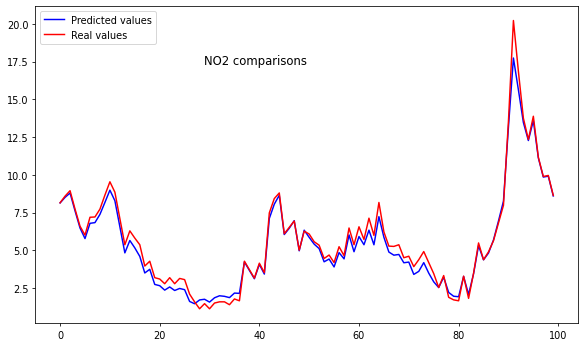

In [27]:
plt.figure(num=None, dpi=70, figsize=(10, 6),facecolor='w', edgecolor='k')
plt.plot(NO2_pred[0:100], "-b", label="Predicted values")
plt.plot(NO2_real[1:101], "-r", label="Real values")
plt.legend(loc="upper left")
plt.title('NO2 comparisons', x=0.5, y=0.8, loc='right')
plt.show()

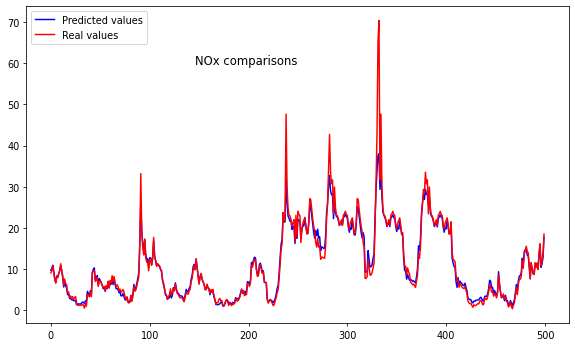

In [ ]:
plt.figure(num=None, dpi=70, figsize=(10, 6),facecolor='w', edgecolor='k')
plt.plot(NOx_pred[0:500], "-b", label="Predicted values")
plt.plot(NOx_real[1:501], "-r", label="Real values")
plt.legend(loc="upper left")
plt.title('NOx comparisons', x=0.5, y=0.8, loc='right')
plt.show()

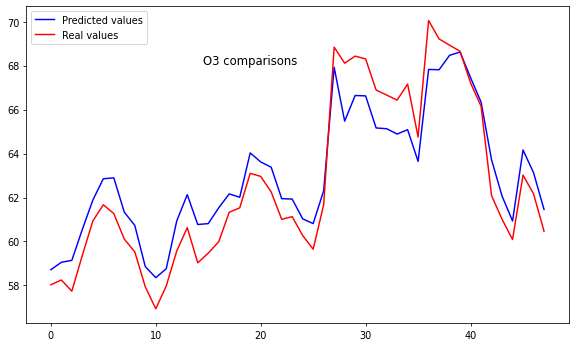

In [ ]:
plt.figure(num=None, dpi=70, figsize=(10, 6),facecolor='w', edgecolor='k')
plt.plot(O3_pred[0:48], "-b", label="Predicted values")
plt.plot(O3_real[1:49], "-r", label="Real values")
plt.legend(loc="upper left")
plt.title('O3 comparisons', x=0.5, y=0.8, loc='right')
plt.show()